In [12]:
# Load relevant libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix

# If you are loading the data from drive, load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

In [8]:
# Reading the data, data relabling, data concatenation 

df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal", 
                 1 : "abnormal"}

num_cols = df_ptbd_normal.shape[1] - 1 

# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal],axis=0,ignore_index=True)

# The last column contains the labels
# label 0 = normal
# label 1 = abnormal
df_ptbd =df_ptbd.rename(columns={187: 'label'})

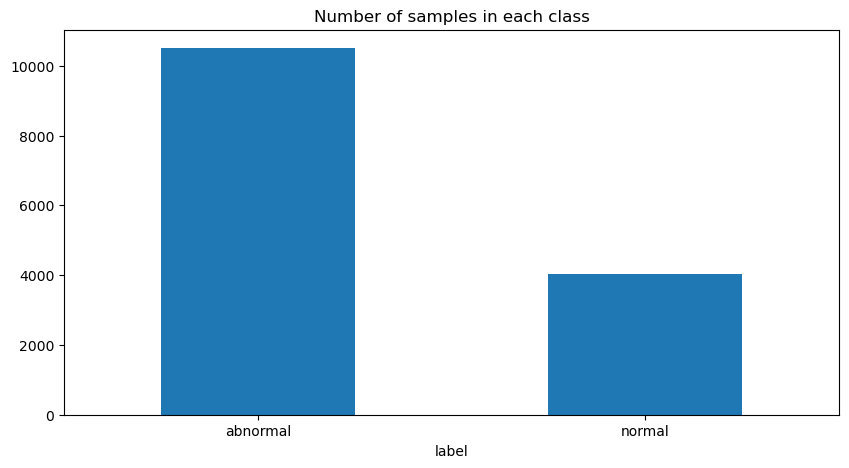

In [9]:
# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class


counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure 
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

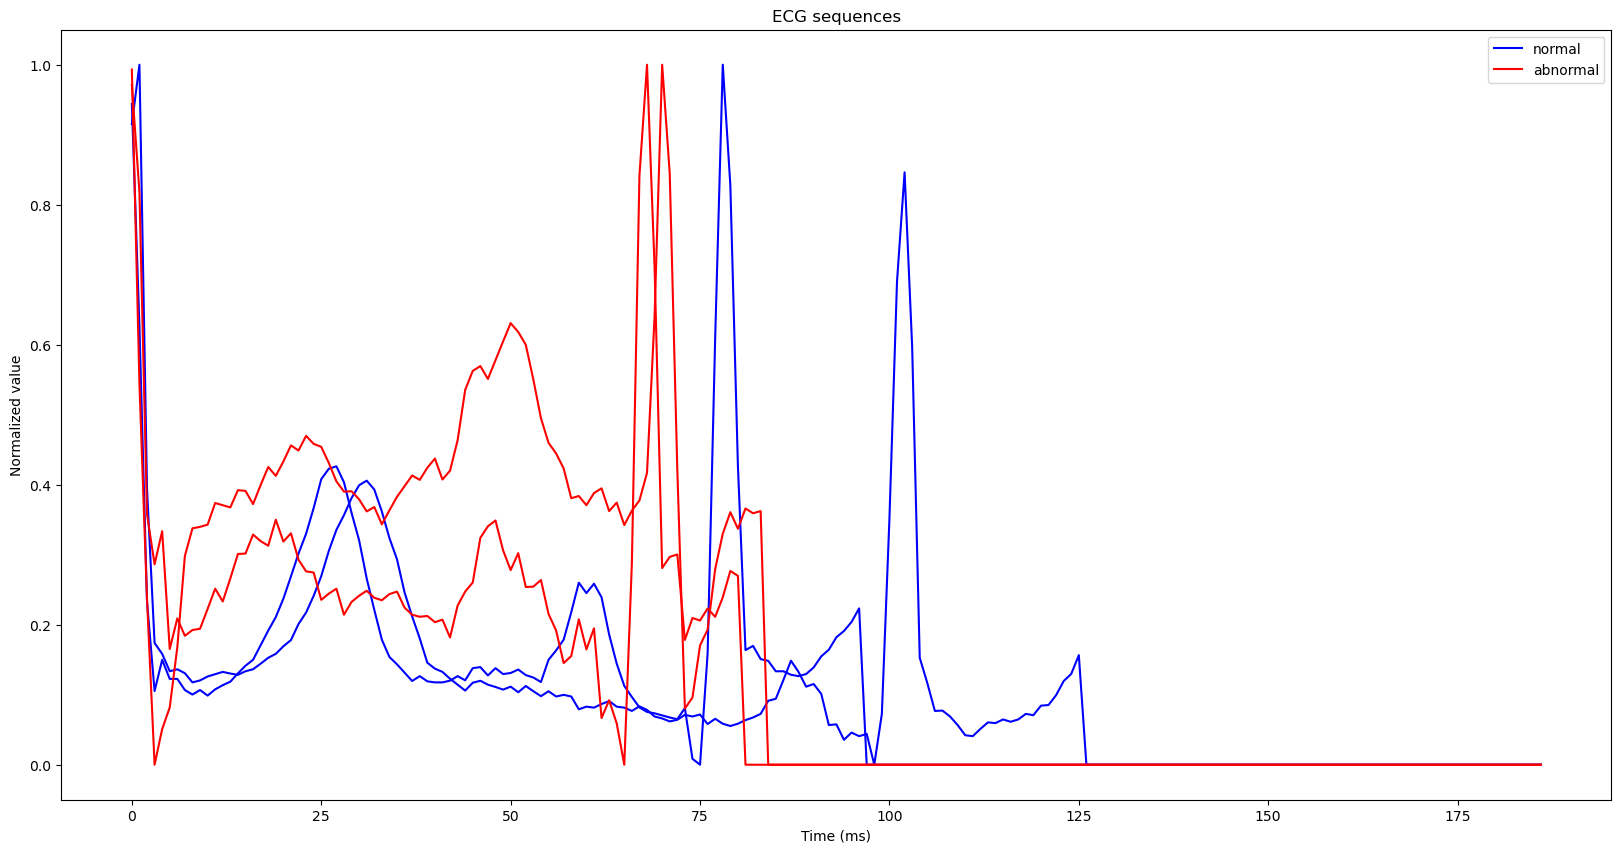

In [10]:
# plot a a row of the dataframe
# select 2 random sequences with class 0 (normal) and 10 with class 1 (abnormal)

df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(2)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(2)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:   
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [26]:
# Splitting the model into train and test. 


df_ptbd_train, df_ptbd_test = train_test_split(df_ptbd, shuffle = True,random_state = 41,test_size = .2,
                                               stratify = y)
                                                                                                                                                

# 5-fold cross validation
n_splits = 5
kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=41)

# Creating an array of accuracies and training our model 
cutoffs = np.arange(0.2,0.8,0.1)
log_reg_accs = np.zeros((len(cutoffs),n_splits))
mean_accuracy_score = np.zeros(((len(cutoffs),1)))

j = 0
for cutoff in cutoffs:
    i = 0
    for train_index, test_index in kfold.split(df_ptbd_train,df_ptbd_train.label):
        df_ptbd_tt = df_ptbd_train.iloc[train_index]
        df_ptbd_val = df_ptbd_train.iloc[test_index]
        X_tt = df_ptbd_tt.drop("label",axis=1)
        y_tt = df_ptbd_tt["label"]
        X_val = df_ptbd_val.drop("label",axis=1)
        y_val = df_ptbd_val["label"]
        log_reg = LogisticRegression(penalty=None,max_iter=10000)
        log_reg.fit(X_tt.values, y_tt.values.reshape(-1))
        pred = np.int64(log_reg.predict_proba(X_val.values)[:,1] >= cutoff)
        log_reg_accs[j,i] = accuracy_score(y_val.values, pred)
        i += 1
    j += 1
                               
for i in range(len(cutoffs)):                     
    mean_accuracy_score[i,0] = np.mean(log_reg_accs[i,:])

print(mean_accuracy_score)

[[0.77149725]
 [0.79915827]
 [0.81865906]
 [0.82260992]
 [0.81393438]
 [0.79151406]
 [0.73825488]]


In [30]:
for i in range(len(cutoffs)):
    print("For cutoff ="+str(cutoffs[i])+",the accuracy score is"+str(mean_accuracy_score[i]))

For cutoff =0.2,the accuracy score is[0.77149725]
For cutoff =0.30000000000000004,the accuracy score is[0.79915827]
For cutoff =0.4000000000000001,the accuracy score is[0.81865906]
For cutoff =0.5000000000000001,the accuracy score is[0.82260992]
For cutoff =0.6000000000000001,the accuracy score is[0.81393438]
For cutoff =0.7000000000000002,the accuracy score is[0.79151406]
For cutoff =0.8000000000000003,the accuracy score is[0.73825488]


In [31]:
# Choosing cutoff of 0.5 is the best from above 

cutoff = 0.5
X_test = df_ptbd_test.drop("label",axis=1)
y_test = df_ptbd_test["label"]

print(accuracy_score(y_test.values, np.int64(log_reg.predict_proba(X_test.values)[:,1] >= cutoff)))

0.829611817244933


In [32]:
print("Confusion Matrix for a cutoff of ",cutoff)
print(confusion_matrix(y_test.values, 
                       np.int64(log_reg.predict_proba(X_test.values)[:,1] >= cutoff)))

Confusion Matrix for a cutoff of  0.5
[[ 498  311]
 [ 185 1917]]


In [33]:
fprs, tprs, cutoffs = roc_curve(y_test.values, log_reg.predict_proba(X_test.values)[:,1])

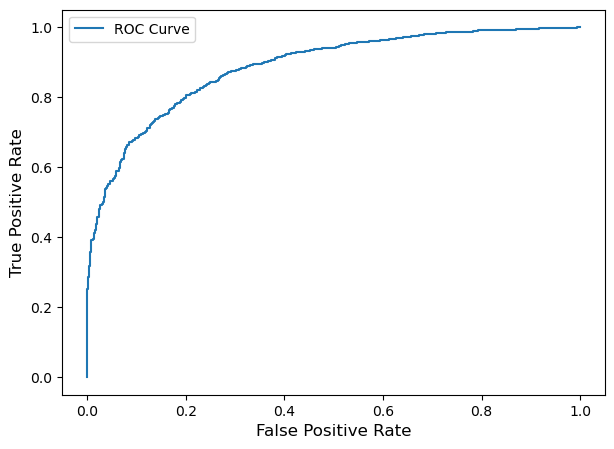

In [35]:
plt.figure(figsize=(7,5))

plt.plot(fprs, tprs, label="ROC Curve")
#plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()